### Import neccessary modules:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [2]:
train = pd.read_csv("train_ctrUa4K.csv")
test = pd.read_csv("test_lAUu6dG.csv")
sample_sub = pd.read_csv("sample_submission_49d68Cx.csv")

train.shape, test.shape, sample_sub.shape

((614, 13), (367, 12), (367, 2))

In [3]:
print (list(train.columns))
print (list(test.columns))
print (list(sample_sub.columns))

['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']
['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area']
['Loan_ID', 'Loan_Status']


Let's not split the dataset into train / Val instead let's opt to do a cross validation using KerasRegressor wrapper using sklearn's cross validate.

### EDA:

For the purposes of EDA let's join the Train and test set together:

In [4]:
train.shape

(614, 13)

In [5]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [7]:
train.nunique()

Loan_ID              614
Gender                 2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           203
Loan_Amount_Term      10
Credit_History         2
Property_Area          3
Loan_Status            2
dtype: int64

Our analysis:

- Loan_Status is the value we are trying to predict.
- Loan_Status, property_area, credit_history, self_employed, education, dependents, married, gender are all *Categorical columns*
- ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term are all continuous variables.
- Although the company seems to have fixed terms for 'loan_ammount_term' (let's divide by 12 -> months to years)
- Loan_ID is unique identifier
- Applicant_income is in int while remaining continuous columns are floats.

Let's suitably typecast them and also scale the *Loan_Amount_Term*:

In [8]:
# categorical columns
cat_cols = ['Gender', 'Married', 'Dependents', 
            'Education', 'Self_Employed', 'Credit_History', 
            'Property_Area', 'Loan_Status']

# convert applicant_income from int to float (Train & test)
train['ApplicantIncome'] = train['ApplicantIncome'].astype('float')
test['ApplicantIncome'] = test['ApplicantIncome'].astype('float')

# type cast for train dataset
train[cat_cols] = train[cat_cols].astype("category")
test[cat_cols[:-1]] = test[cat_cols[:-1]].astype("category")

# convert Loan_amount_term to years (scaling)
train['Loan_Amount_Term'] /= 12
test['Loan_Amount_Term'] /= 12

#### For futher EDA down the line let's create a helper function to help us plot stacked bar charts:

In [9]:
def compare_with_bar(df, col1, col2):
    '''
    Creates a stacked bar chart for comparing two columns
    Col1 is the feature we are comparing against one another
    Col2 is the target feature
    '''

    # choosing loan_id since its unique
    temp = df.groupby([col1, col2])['Loan_ID'].count().reset_index()

    bottom = 0
    plots = []
    col2_cat = df[col2].cat.categories
    for target in col2_cat:
        k = temp[['Loan_ID', col1]][temp[col2] == target]
        plots.append(plt.bar(k[col1], k['Loan_ID'], bottom=bottom))
        bottom = k['Loan_ID']

    plt.xticks(range(len(k)))
    plt.legend(map(lambda x: x[0], plots), col2_cat);

#### Let's write another function that creates pie chart given a dataframe. It creates a pie chart based on the *cat_cols* to help develop on our intution further:

In [10]:
def categorize2pie(df, cols=cat_cols):
    f, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    ax = ax.ravel()

    # visualize all columns in a loop except the target
    for i, col in enumerate(cols):
        temp = df[col].value_counts()
        
        ax[i].pie(temp.values, textprops={'color':'white'}, labels=temp.index, 
                  # (percentage, actual count)
                  autopct=lambda val: (int(val), int(val/100*len(df))))
        
        ax[i].set_title(col, color='white')

#### Visualize the overall distribution:

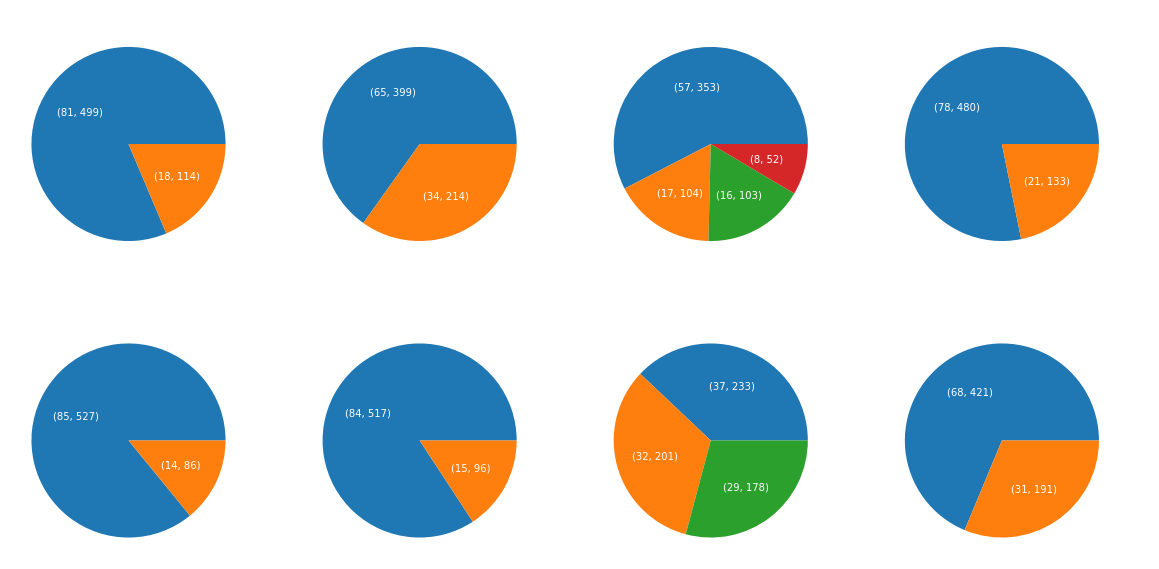

In [11]:
categorize2pie(train)

#### How important is `Credit_History`?

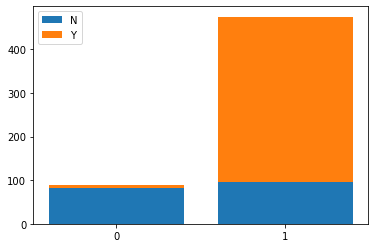

In [12]:
compare_with_bar(train, 'Credit_History', 'Loan_Status')

We observe that bad history implies the loan almost never being sanctioned. However there are cases where loan is refused inspite of having a good history. Let's examine those cases:

In [13]:
print ("*" * 75)
print ("OVERALL Cat attributes stats:\n")
temp = train.describe(include='category').drop(['Loan_Status', 'Credit_History'], axis=1)
temp.loc['ratio'] = temp.loc['freq'] / temp.loc['count']
print (temp.drop('unique'))
print ("*" * 75)

for status, hist in [('N', 0.0), ('Y', 0.0), ('N', 1.0), ('Y', 1.0)]:
    temp = (train[(train.Loan_Status == status) & (train.Credit_History == hist)]
    .describe(include='category')
    .drop(['Loan_Status', 'Credit_History'], axis=1))

    temp.loc['ratio'] = temp.loc['freq'] / temp.loc['count']
    print ("*" * 75)
    print (f"* Loan {'GIVEN;' if status == 'Y' else 'REFUSED;'} {'GOOD' if hist else 'BAD'} Credit History.\n")
    print (temp.drop('unique'))
    print ("*" * 75)

***************************************************************************
OVERALL Cat attributes stats:

         Gender   Married Dependents Education Self_Employed Property_Area
count       601       611        599       614           582           614
top        Male       Yes          0  Graduate            No     Semiurban
freq        489       398        345       480           500           233
ratio  0.813644  0.651391    0.57596  0.781759      0.859107      0.379479
***************************************************************************
***************************************************************************
* Loan REFUSED; BAD Credit History.

         Gender   Married Dependents Education Self_Employed Property_Area
count        79        82         77        82            81            82
top        Male       Yes          0  Graduate            No         Urban
freq         63        53         42        57            69            30
ratio  0.797468  0.646341   0

It appears that `Property_Area` being *Semiurban* has a higher chance of loan being sanctioned. Let's confirm that its a corelation and just casuation due to large numbers:

In [14]:
train['Property_Area'][train.Loan_Status == 'Y'].value_counts()

Semiurban    179
Urban        133
Rural        110
Name: Property_Area, dtype: int64

In [15]:
train['Property_Area'][train.Loan_Status == 'N'].value_counts()

Urban        69
Rural        69
Semiurban    54
Name: Property_Area, dtype: int64

Our suspicions are indeed true. 

#### Let's visualize in depth with pie charts for different property types:

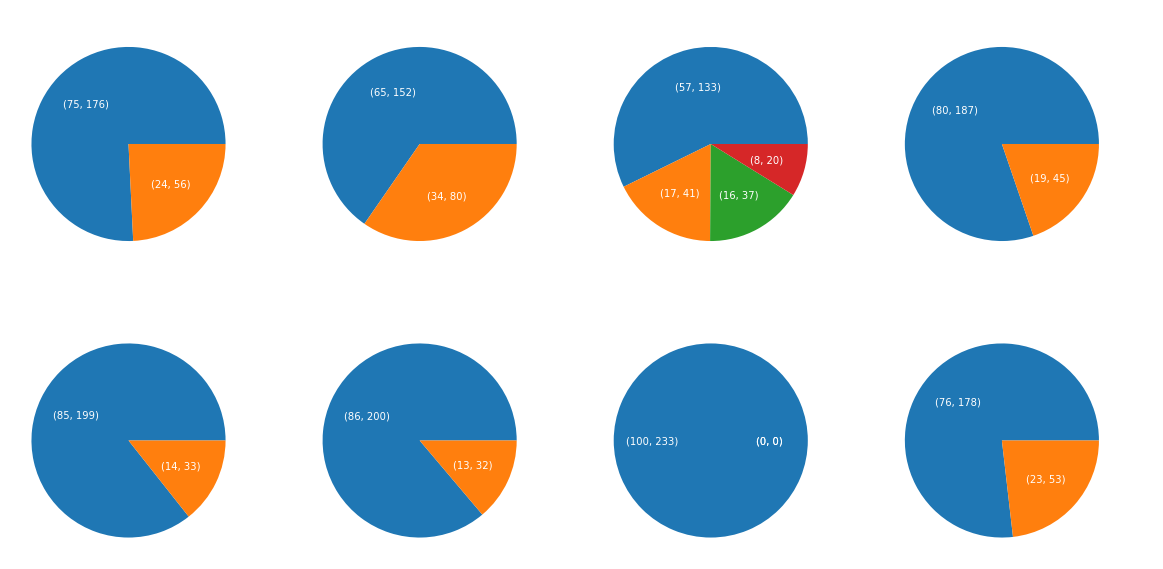

In [16]:
categorize2pie(train[train.Property_Area == 'Semiurban'])

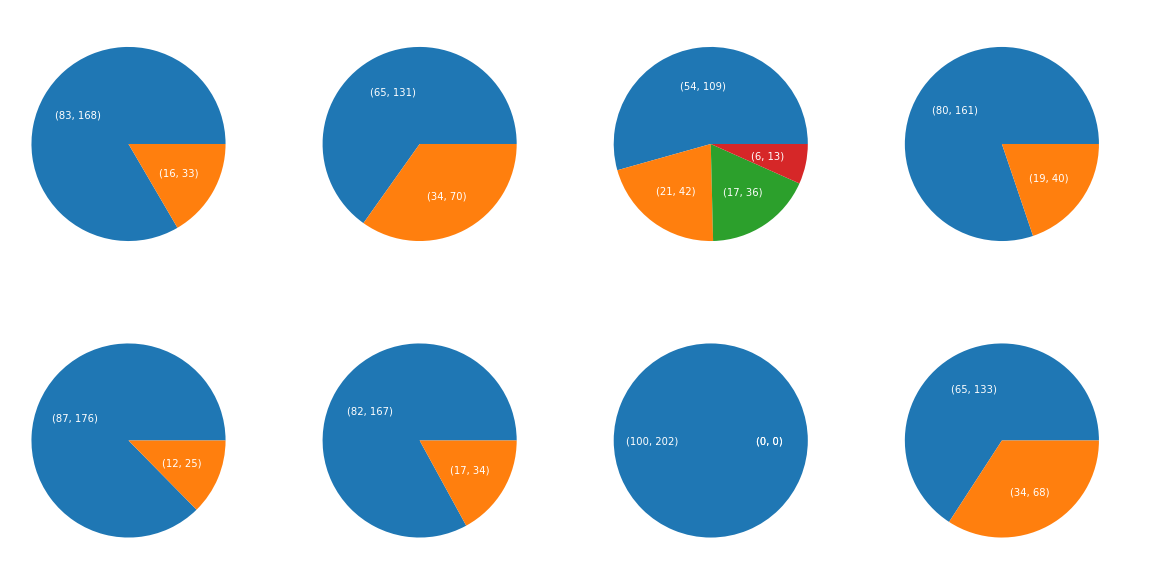

In [17]:
categorize2pie(train[train.Property_Area == 'Urban'])

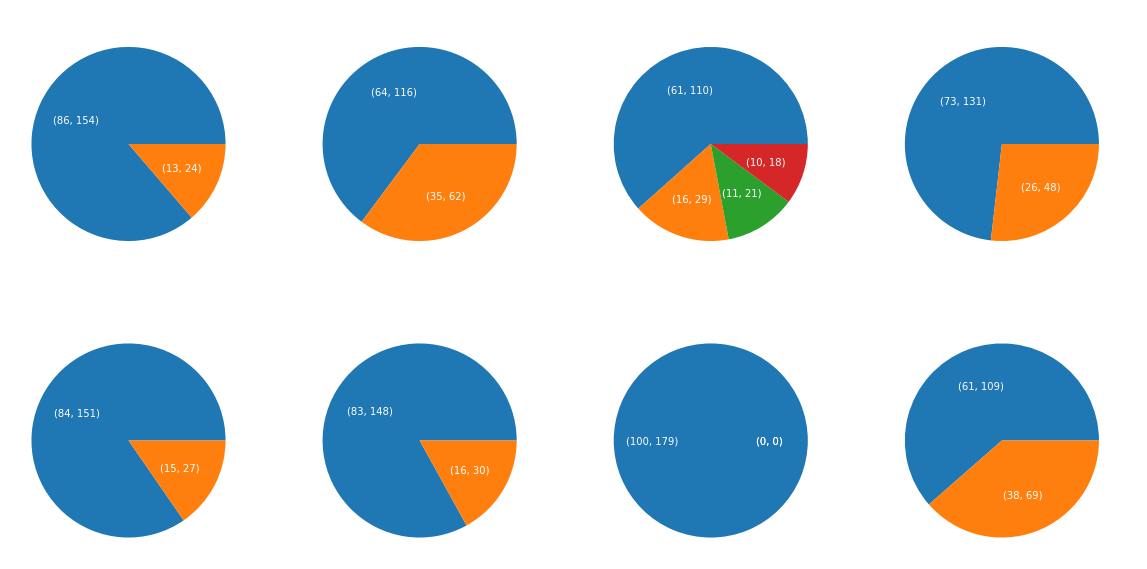

In [18]:
categorize2pie(train[train.Property_Area == 'Rural'])

Semiurban clearly has greater chance of loan sanctioning, however there may be another cause to it: *Higher number of females* in the semi urban areas or *Dependents* might be a cause?

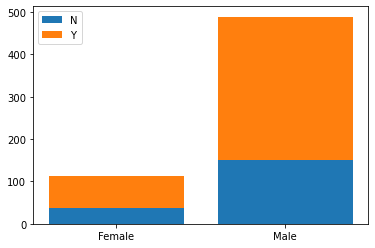

In [19]:
# male vs Female influencing loan?
compare_with_bar(train, 'Gender', 'Loan_Status')

Males are greater in number however it doesn't seem to be influencing the outcome in any way.

What about dependents?

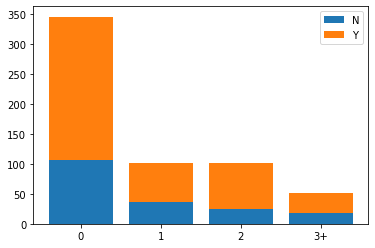

In [20]:
compare_with_bar(train, 'Dependents', 'Loan_Status')

Interstingly those applicants with 2 and 0 dependents have greater chance of being approved. Let's split and view them on the basis of Gender and Married as well:

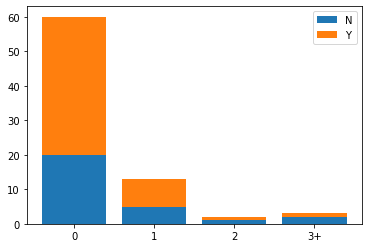

In [21]:
compare_with_bar(train[(train.Gender == 'Female') & (train.Married == 'No')], 'Dependents', 'Loan_Status')

So from our analysis the following features are important:

1. Credit history (most important)
2. Property_Area
3. Married * Gender (since it affects differently for both genders)

Let' sort out the confusion we have with the `Loan_Amount_Term` once and for all:

In [22]:
# loan_amt_term as numeric feature
pd.get_dummies(train[['Loan_Status', 'Loan_Amount_Term']]).corr()['Loan_Status_Y']

Loan_Amount_Term   -0.021268
Loan_Status_N      -1.000000
Loan_Status_Y       1.000000
Name: Loan_Status_Y, dtype: float64

In [23]:
# loan_amt_term as a categorical feature
pd.get_dummies(
    pd.DataFrame(data={"Term:": train.Loan_Amount_Term.astype('category'), "Target": train.Loan_Status}),
    drop_first=True
    ).corr()["Target_Y"]

Term:_3.0    -0.084751
Term:_5.0     0.038560
Term:_7.0     0.010953
Term:_10.0    0.047264
Term:_15.0   -0.016904
Term:_20.0    0.010953
Term:_25.0   -0.022814
Term:_30.0    0.067057
Term:_40.0   -0.098067
Target_Y      1.000000
Name: Target_Y, dtype: float64

There's a much better corelation to `Loan_Amount_Term` as a categorical feature. So let's type cast it:

In [24]:
# type cast for train and test
train['Loan_Amount_Term'] = train['Loan_Amount_Term'].astype('category')
test['Loan_Amount_Term'] = test['Loan_Amount_Term'].astype('category')

cat_cols.append("Loan_Amount_Term")

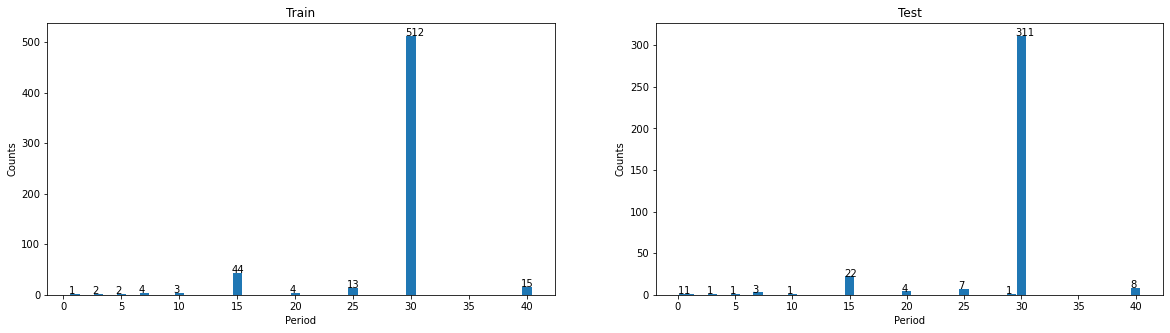

In [25]:
# visualise the LOAN DURATION for TRAIN & TEST
f, ax = plt.subplots(ncols=2, figsize=(20, 5))

temp = train.Loan_Amount_Term.value_counts()
ax[0].bar(temp.index, temp.values)
ax[0].set(title="Train", xlabel='Period', ylabel='Counts')

for index, value in zip(temp.index, temp.values):
    ax[0].text(index-0.5, value, str(value), fontdict={'fontsize':10})

temp = test.Loan_Amount_Term.value_counts()
ax[1].bar(temp.index, temp.values)
ax[1].set(title="Test", xlabel='Period', ylabel='Counts')

for index, value in zip(temp.index, temp.values):
    ax[1].text(index-0.5, value, str(value), fontdict={'fontsize':10});

In [26]:
# those rows in the test set which donot match with the train (IGNORE NAN's for now)
test[~test.Loan_Amount_Term.isin(train.Loan_Amount_Term.cat.categories)].dropna()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
157,LP001867,Male,Yes,0,Graduate,No,4333.0,2291,133.0,29.166667,1.0,Rural
325,LP002802,Male,No,0,Graduate,No,2875.0,2416,95.0,0.500000,0.0,Semiurban


In [27]:
# let's convert these to their nearest Loan_Amount_Term
test.loc[157, "Loan_Amount_Term"] = 30.0
test.loc[325, "Loan_Amount_Term"] = 1.0
test.loc[[157, 325]]

test['Loan_Amount_Term'].cat.remove_unused_categories(inplace=True)

In [28]:
for col in test.select_dtypes('category').columns:
    if set(test[col].cat.categories) == set(train[col].cat.categories):
        print (">", col, "is a match!")
    else:
        print ("X", col.upper(), "doesn't match!")

> Gender is a match!
> Married is a match!
> Dependents is a match!
> Education is a match!
> Self_Employed is a match!
> Loan_Amount_Term is a match!
> Credit_History is a match!
> Property_Area is a match!


### Let's obtain their summary statistics:

In [29]:
# categorical columns (ignore the target column)
train.describe(include='category')

,Gender,Married,Dependents,Education,Self_Employed,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,601,611,599,614,582,600.0,564.0,614,614
unique,2,2,4,2,2,10.0,2.0,3,2
top,Male,Yes,0,Graduate,No,30.0,1.0,Semiurban,Y
freq,489,398,345,480,500,512.0,475.0,233,422


In [30]:
# Numeric features (Exclude the Loan Duration)
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount
count,614.000000,614.000000,592.000000
mean,5403.459283,1621.245798,146.412162
std,6109.041673,2926.248369,85.587325
min,150.000000,0.000000,9.000000
25%,2877.500000,0.000000,100.000000
50%,3812.500000,1188.500000,128.000000
75%,5795.000000,2297.250000,168.000000
max,81000.000000,41667.000000,700.000000


### Check the correlation for all the columns to target:

In [31]:
pd.get_dummies(
    train, columns=cat_cols, 
    drop_first=True).corr()['Loan_Status_Y']

ApplicantIncome           -0.004710
CoapplicantIncome         -0.059187
LoanAmount                -0.037318
Gender_Male                0.025407
Married_Yes                0.084281
Dependents_1              -0.038740
Dependents_2               0.062384
Dependents_3+             -0.026123
Education_Not Graduate    -0.085884
Self_Employed_Yes         -0.003700
Credit_History_1.0         0.432616
Property_Area_Semiurban    0.136540
Property_Area_Urban       -0.043621
Loan_Status_Y              1.000000
Loan_Amount_Term_3.0      -0.084751
Loan_Amount_Term_5.0       0.038560
Loan_Amount_Term_7.0       0.010953
Loan_Amount_Term_10.0      0.047264
Loan_Amount_Term_15.0     -0.016904
Loan_Amount_Term_20.0      0.010953
Loan_Amount_Term_25.0     -0.022814
Loan_Amount_Term_30.0      0.067057
Loan_Amount_Term_40.0     -0.098067
Name: Loan_Status_Y, dtype: float64

Check the number of missing values (train & test seperately):

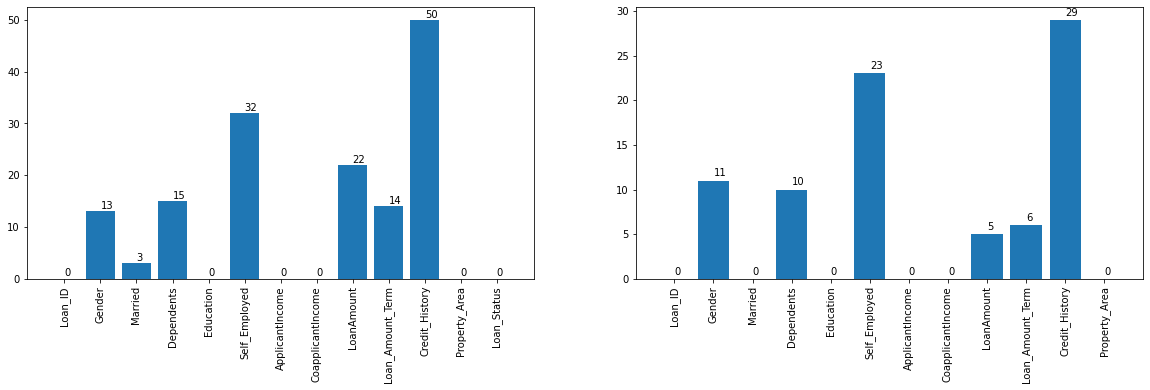

In [32]:
train_missing = train.isna().sum()
test_missing = test.isna().sum()

f, ax = plt.subplots(ncols=2, figsize=(20, 5))
ax[0].bar(train_missing.index, train_missing.values)
ax[0].set_xticklabels(train_missing.index, rotation=90)
ax[1].bar(test_missing.index, test_missing.values)
ax[1].set_xticklabels(train_missing.index, rotation=90)

for index, d in enumerate(train_missing):
    ax[0].text(x=index, y=d+0.5, s=str(d) , fontdict=dict(fontsize=10))

for index, d in enumerate(test_missing):
    ax[1].text(x=index, y=d+0.5, s=str(d) , fontdict=dict(fontsize=10));

Lets check how these missing values have been stratified to Y and N groups for the train dataset:

Refer <a href=https://stackoverflow.com/questions/53947196/groupby-class-and-count-missing-values-in-features>StackOverFlow</a>

In [33]:
(
    train
    # we don't need to count missing values for loan_status
    .drop(train_missing[train_missing == 0].index, axis=1)
    # returns a dataframe of True and False for every colxrow
    .isna().groupby(train['Loan_Status'])
    # sum adds up all TRUE's as 1
    .sum().astype(np.int32)
)

,Gender,Married,Dependents,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History
Loan_Status,,,,,,,
N,5,0,6,9,11,6,13
Y,8,3,9,23,11,8,37


Let's observe their skews to decide on use mean or median:

In [34]:
# numerically
train.select_dtypes('float').skew()

ApplicantIncome      6.539513
CoapplicantIncome    7.491531
LoanAmount           2.677552
dtype: float64

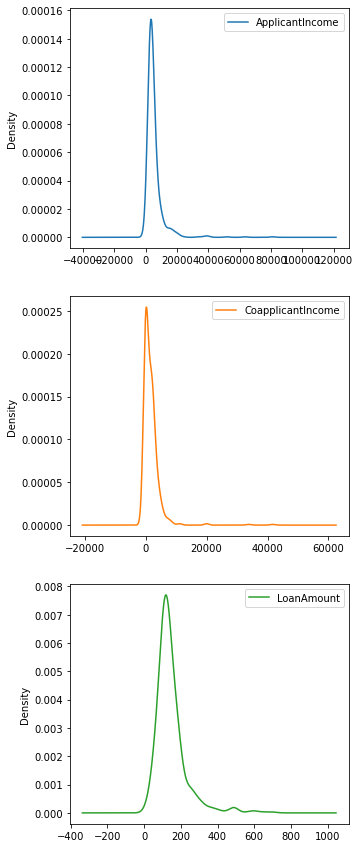

In [35]:
train.select_dtypes('float').plot(kind='kde', subplots=True, figsize=(5, 15), sharex=False);

Hanlde missing values as follows:
- Married with *mode*
- Self employed with *mode*
- Gender with *mode*
- Dependents with *mode*
- Fill Loan_Amount with mean
- Fill loan Amount term with mode (categorical)
- Credit history is an important predictor of target. Let's create seperate label 'missing' for those that have it missing.

Further, the test dataset does not contain missing values besides those in the above columns. Let's get to imputing these data from both datasets:

In [36]:
# let's first add provision for these spl flags before adding them
train.Credit_History.cat.add_categories([2], inplace=True)

# Assign missing values with spl flags
train['Credit_History'].fillna(2, inplace=True)

# fill missing categorical columns with mode or mean depending on dtype
train = train.apply(lambda x: x.fillna(x.mode()[0] if x.dtype.name == 'category' else (x.mean() if x.name != 'Loan_ID' else x)))

In [37]:
# let's first add provision for these spl flags before adding them
test.Credit_History.cat.add_categories([2], inplace=True)

# Assign missing values with spl flags
test['Credit_History'].fillna(2, inplace=True)

# fill missing categorical columns with mode or mean depending on dtype
test = test.apply(lambda x: x.fillna(x.mode()[0] if x.dtype.name == 'category' else (x.mean() if x.name != 'Loan_ID' else x)))

In [38]:
# missing values?
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

Categorical columns are okay, let's dive into the numeric ones and check for presence of outliers:

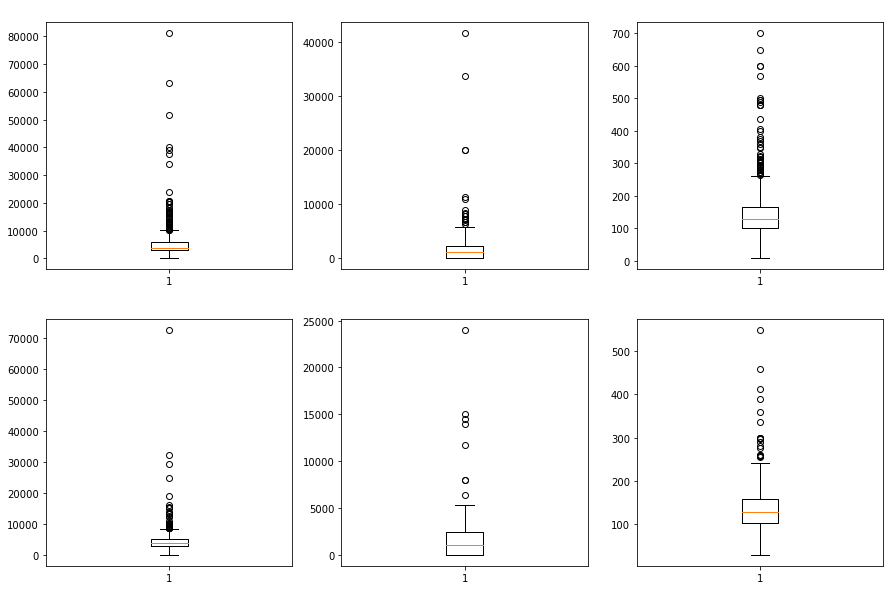

In [39]:
num_cols = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]
f, ax = plt.subplots(figsize=(15, 10), ncols=3, nrows=2)
for i, col in enumerate(num_cols):
    temp = train[col]
    ax[0][i].boxplot(temp)
    ax[0][i].set_title("Train_"+col, color='white')
    
    temp = test[col]
    ax[1][i].boxplot(temp)
    ax[1][i].set_title("Test_"+col, color='white')

#### Clipping values:
* ApplicantIncome: 15k
* CoapplicantIncome: 5k
* LoanAmount: 275

In [40]:
AI = 15000 # applicant clip value
CAI = 5000 # co applicant clip value
LA = 275 # Loan amount clip value

train['ApplicantIncome'].clip(upper=AI, inplace=True)
test['ApplicantIncome'].clip(upper=AI, inplace=True)

train['CoapplicantIncome'].clip(upper=CAI, inplace=True)
test['CoapplicantIncome'].clip(upper=CAI, inplace=True)

train['LoanAmount'].clip(upper=LA, inplace=True)
test['LoanAmount'].clip(upper=LA, inplace=True)

How are the Income & Loan amount related to getting a loan?

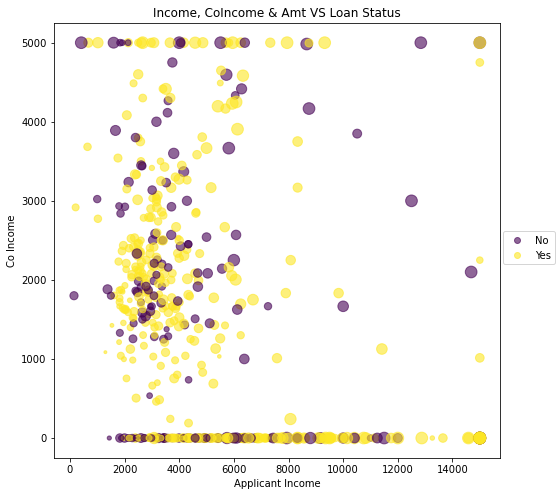

In [41]:
f, ax = plt.subplots(figsize=(8, 8))
sc = ax.scatter("ApplicantIncome", "CoapplicantIncome", s=train.LoanAmount/2, c=train.Loan_Status.cat.codes, data=train, alpha=0.6)
ax.set(xlabel="Applicant Income", ylabel="Co Income", title="Income, CoIncome & Amt VS Loan Status")
f.legend(loc='center right', handles=sc.legend_elements()[0], labels=('No', 'Yes'));

### Feature engineering:

In [42]:
# columns available
train.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849.0,0.0,146.412162,30.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583.0,1508.0,128.000000,30.0,1.0,Rural,N


In [43]:
train.Loan_ID.is_monotonic_increasing, test.Loan_ID.is_monotonic_increasing

(True, True)

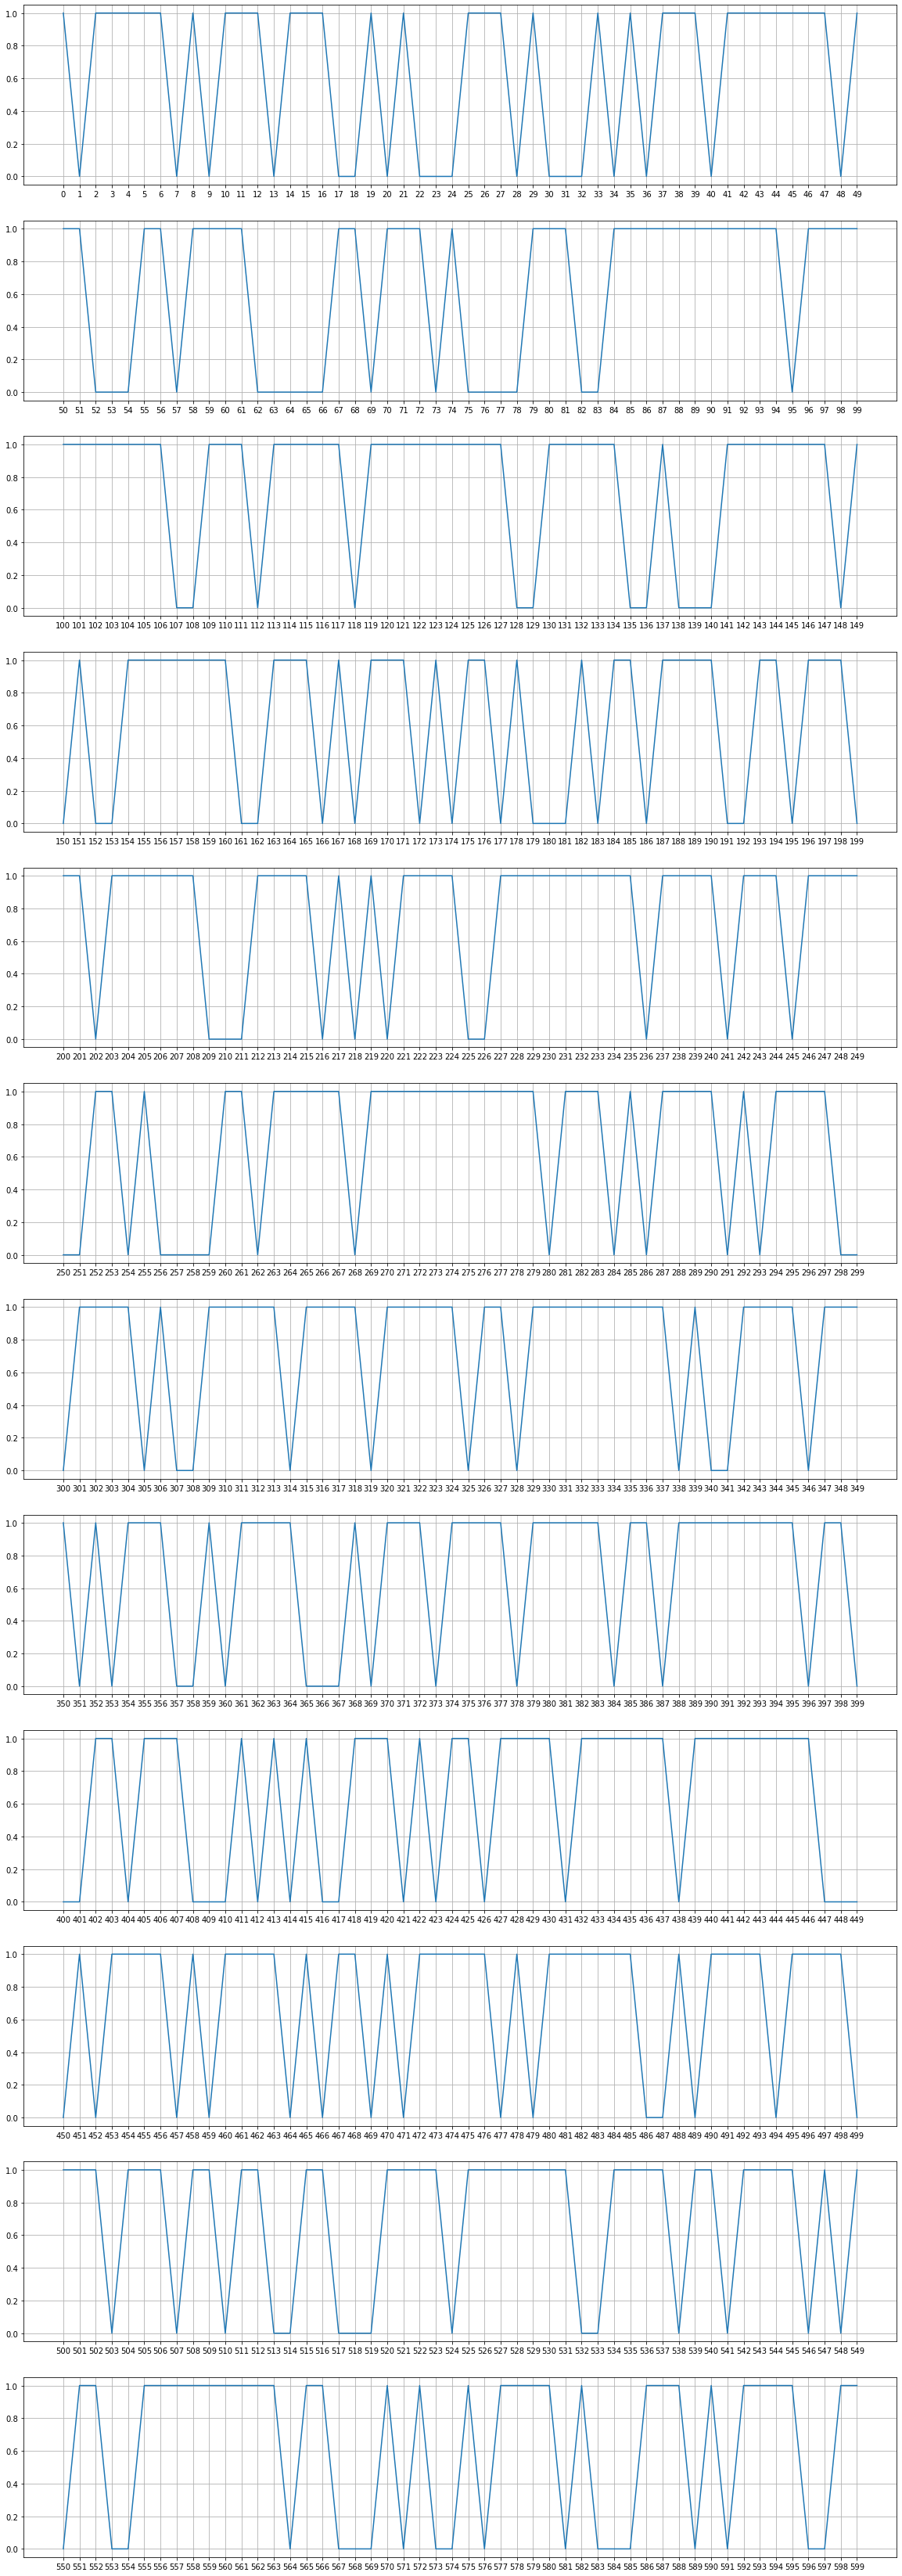

In [44]:
rows = int(train.shape[0]/50)
f, ax = plt.subplots(nrows=rows, figsize=(20, 5*rows))
ax = ax.ravel()
prev_step = 0
for i, step in enumerate(range(50, train.shape[0], 50)):
    ax[i].plot(train.Loan_Status.iloc[prev_step:step].cat.codes)
    ax[i].grid(True)
    ax[i].set_xticks(range(prev_step, step))
    prev_step = step

#### To convert the columns to codes and perform one hot encoding, let's combine the test and train set together:

In [45]:
# filling test target with dummy value
test['Loan_Status'] = 'N'

train_ids = train['Loan_ID']
test_ids = test['Loan_ID']

data = pd.concat([train, test])

def preprocess_series(x):
    '''Preprocesses the output depending on its dtype and name
    to be applied to the apply function
    '''

    if x.name == 'Loan_ID': # return as is if loan_ID
        return x
    
    elif x.name == 'Loan_Status': # obj + cat concatenation results in obj, cast before returning codes
        return x.astype('category').cat.codes

    else:
        if x.dtype.name == 'category':
            return x.cat.codes
        else: # zscore scaling
            return (x - x.mean()) / x.std()


# convert all categorical columns to codes and scale the numeric ones
data = data.apply(preprocess_series)

# Excluding the binary columns, do one hot encoding to the rest
data = pd.get_dummies(
    data, 
    columns=['Dependents', 'Self_Employed', 'Property_Area', 'Loan_Amount_Term'], 
    drop_first=True)

data.head()

,Loan_ID,Gender,Married,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Loan_Status,Dependents_1,...,Property_Area_2,Loan_Amount_Term_1,Loan_Amount_Term_2,Loan_Amount_Term_3,Loan_Amount_Term_4,Loan_Amount_Term_5,Loan_Amount_Term_6,Loan_Amount_Term_7,Loan_Amount_Term_8,Loan_Amount_Term_9
0,LP001002,1,0,0,0.351387,-0.903278,0.172961,1,1,0,...,1,0,0,0,0,0,0,0,1,0
1,LP001003,1,1,0,-0.059229,0.074282,-0.160751,1,0,1,...,0,0,0,0,0,0,0,0,1,0
2,LP001005,1,1,0,-0.572661,-0.903278,-1.284475,1,1,0,...,1,0,0,0,0,0,0,0,1,0
3,LP001006,1,1,1,-0.707911,0.625294,-0.305748,1,1,0,...,1,0,0,0,0,0,0,0,1,0
4,LP001008,1,0,0,0.400362,-0.903278,0.074868,1,1,0,...,1,0,0,0,0,0,0,0,1,0


In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# clf = LogisticRegression(C=0.1, penalty='l1', solver='liblinear')
clf = RandomForestClassifier(n_estimators=200)

# Non missing column ids
non_missing_ids = (data.Credit_History != 2)

# fit the model on the data
clf.fit(data[non_missing_ids].drop(["Credit_History", "Loan_ID", "Loan_Status"], axis=1),
     data.Credit_History[non_missing_ids])

# make predictions 
missing_fill = clf.predict(data[~non_missing_ids].drop(["Credit_History", "Loan_ID", "Loan_Status"], axis=1))

# fill with the predicted vales
data.loc[~non_missing_ids, 'Credit_History'] = missing_fill

# any missing values?
data[data.Credit_History == 2]

,Loan_ID,Gender,Married,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Loan_Status,Dependents_1,...,Property_Area_2,Loan_Amount_Term_1,Loan_Amount_Term_2,Loan_Amount_Term_3,Loan_Amount_Term_4,Loan_Amount_Term_5,Loan_Amount_Term_6,Loan_Amount_Term_7,Loan_Amount_Term_8,Loan_Amount_Term_9


In [47]:
train = data[data.Loan_ID.isin(train_ids)]
test = data[data.Loan_ID.isin(test_ids)].drop("Loan_Status", axis=1)

train.shape, test.shape

((614, 24), (367, 23))

### Let's get to modelling our data:

In [50]:
def build_model(inp_shape=(22,), n_hidden=2, n_neurons=64, drate=0.2, opt='rmsprop'):

    if type(n_neurons) == int:
        n_neurons = [n_neurons] * n_hidden

    # ensure the no of layers and neurons match
    assert n_hidden == len(n_neurons)

    # create the keras sequential model
    model = tf.keras.models.Sequential()

    # input layer
    model.add(tf.keras.layers.Input(shape=inp_shape))

    # Dense followed by dropouts
    for units in n_neurons:
        model.add(tf.keras.layers.Dense(units, activation='elu', kernel_initializer='he_normal'))
        model.add(tf.keras.layers.Dropout(drate))

    # output layer with sigmoid activation
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # compiling the model
    model.compile(loss='binary_crossentropy', metrics='accuracy', 
                  optimizer=opt)
    
    return model

In [54]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

# creating a keras wrapper for parameter fine tuning
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model, epochs=20, verbose=0)

# possible parameters to fine tune from
model_params = {
    "n_hidden": [1, 2, 3, 4],
    "n_neurons": [4, 8, 12, 16, 32, 64],
    "drate": [0.05, 0.1, 0.2, 0.25]
}

# create the grid search object
grid = GridSearchCV(model, param_grid=model_params, cv=5, n_jobs=-1)

# fit the model
grid.fit(train.drop(["Loan_Status", "Loan_ID"], axis=1), train["Loan_Status"], verbose=0)
grid.best_params_

/usr/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'drate': 0.25, 'n_hidden': 3, 'n_neurons': 64}

In [55]:
# save the best model to 'model' 0.84
model = grid.best_estimator_.model
grid.best_score_

0.8126882553100586

In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                1472      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

### Lets make predictions on our data:

In [57]:
test = test.merge(pd.DataFrame(
    model.predict(test.drop("Loan_ID", axis=1)) > 0.5, 
    index=test.index, 
    columns=['Loan_Status']),
    
    # merge based on indices
    left_index=True, right_index=True)

# map True with Y and False with N
test['Loan_Status'] = test['Loan_Status'].map({True: 'Y', False: 'N'})

test.head()

,Loan_ID,Gender,Married,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Dependents_1,Dependents_2,...,Loan_Amount_Term_1,Loan_Amount_Term_2,Loan_Amount_Term_3,Loan_Amount_Term_4,Loan_Amount_Term_5,Loan_Amount_Term_6,Loan_Amount_Term_7,Loan_Amount_Term_8,Loan_Amount_Term_9,Loan_Status
0,LP001015,1,1,0,0.309547,-0.903278,-0.486994,1,0,0,...,0,0,0,0,0,0,0,1,0,Y
1,LP001022,1,1,0,-0.548011,0.069096,-0.197001,1,1,0,...,0,0,0,0,0,0,0,1,0,Y
2,LP001031,1,1,0,0.076021,0.263571,1.289215,1,0,1,...,0,0,0,0,0,0,0,1,0,Y
3,LP001035,1,1,0,-0.786726,0.747165,-0.668240,1,0,1,...,0,0,0,0,0,0,0,1,0,Y
4,LP001051,1,0,1,-0.483143,-0.903278,-1.066980,1,0,0,...,0,0,0,0,0,0,0,1,0,Y


In [58]:
# save the output to csv File
test[["Loan_ID", "Loan_Status"]].to_csv("submission.csv", index=False)